In [1]:
from itertools import cycle

from cowerc_adsorption import PhysicalParams, Simulation, ExperimentalBreakthroughData
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patheffects import Stroke
from math import pi
from pathlib import Path

import pandas as pd
from scipy.optimize import Bounds, curve_fit

In [2]:
excel_file = Path("../../.data/Data and Column Properties.xlsx")
sheet_name = "WW All Contaminants 0.18-min"

In [3]:
# Read Emma's excel report
xls_setup = pd.read_excel(excel_file, sheet_name=sheet_name, nrows=18, usecols="A:B", index_col=0)
xls_setup

,Value
Design Parameters,
Column Diameter (cm),0.660000
Column Area (cm^2),0.340000
Particle Size (cm),0.016800
Column Diameter/Particle Size Ratio,39.285714
Reynold&apos;s Number,0.270000
Bed Voidage (ε),0.500000
Hydraulic Loading Rate (cm/s),0.080000
EBCT,0.180000
Flow Rate (mL/s),0.028000


In [4]:
xls_influent = pd.read_excel(excel_file, sheet_name=sheet_name, skiprows=11, nrows=4, usecols="D:J")
xls_influent

,Unnamed: 3,PFOA,PFHxA,PFHxS,BEZ,DCF,PFBA
0,Influent 1,185.0,161.50,376,391.00,318.50,160.0
1,Influent 2,161.0,164.00,347,366.50,355.50,165.5
2,Influent 3,189.5,179.50,411,334.00,326.00,174.0
3,Influent AVG,178.5,168.33,378,363.83,333.33,166.5


In [5]:
xls_btc = pd.read_excel(excel_file, sheet_name=sheet_name, header=19, usecols="A:Q")
xls_btc

,Sample ID,Time (min.),Cum. Vol.,Bed Vol Passed (BV),Specific Throughput,PFOA,PFOA C/C0,PFHxA,PFHxA C/C0,PFHxS,PFHxS C/C0,BEZ,BEZ C/C0,DCF,DCF C/C0,PFBA,PFBA C/C0
0,1,30.000000,49.5,170.689655,825.000000,0.50,0.002801,13.70,0.081386,0.00,0.000000,51.25,0.140861,61.30,0.18390,0.00,0.000000
1,2,91.818182,151.5,522.413793,2525.000000,0.00,0.000000,20.50,0.121782,0.00,0.000000,84.00,0.230875,72.45,0.21735,41.35,0.248348
2,3,277.272727,457.5,1577.586207,7625.000000,11.35,0.063585,43.55,0.258713,10.36,0.027407,154.50,0.424645,99.95,0.29985,128.00,0.768769
3,4,775.454545,1279.5,4412.068966,21325.000000,19.15,0.107283,56.10,0.333267,34.05,0.090079,251.50,0.691251,127.50,0.38250,182.00,1.093093
4,5,1274.848485,2103.5,7253.448276,35058.333333,26.80,0.150140,86.75,0.515347,49.80,0.131746,275.00,0.755841,131.15,0.39345,194.50,1.168168
5,6,2325.757576,3837.5,13232.758621,63958.333333,34.25,0.191877,129.00,0.766337,41.75,0.110450,346.00,0.950985,185.50,0.55650,219.50,1.318318
6,7,2882.121212,4755.5,16398.275862,79258.333333,45.60,0.255462,118.50,0.703960,55.05,0.145635,358.50,0.985341,139.00,0.41700,173.00,1.039039
7,9,3403.333333,5615.5,19363.793103,93591.666667,43.75,0.245098,116.00,0.689109,63.00,0.166667,377.00,1.036189,164.00,0.49200,170.50,1.024024
8,10,3924.545455,6475.5,22329.310345,107925.000000,59.25,0.331933,131.00,0.778218,96.60,0.255556,392.50,1.078791,229.00,0.68700,176.50,1.060060
9,12,4966.969697,8195.5,28260.344828,136591.666667,70.05,0.392437,111.00,0.659406,100.05,0.264683,376.00,1.033440,259.00,0.77700,174.50,1.048048


In [6]:
setup = xls_setup.to_dict()["Value"]

In [7]:
porosity = setup["Bed Voidage (ε)"]
lenght = setup["Bed Length (cm)"]

area = 0.25 * pi * setup["Column Diameter (cm)"] ** 2  # cm²
pore_velocity = setup["Flow Rate (mL/min)"] / (area * porosity)  # cm/min

In [8]:
xls_btc

,Sample ID,Time (min.),Cum. Vol.,Bed Vol Passed (BV),Specific Throughput,PFOA,PFOA C/C0,PFHxA,PFHxA C/C0,PFHxS,PFHxS C/C0,BEZ,BEZ C/C0,DCF,DCF C/C0,PFBA,PFBA C/C0
0,1,30.000000,49.5,170.689655,825.000000,0.50,0.002801,13.70,0.081386,0.00,0.000000,51.25,0.140861,61.30,0.18390,0.00,0.000000
1,2,91.818182,151.5,522.413793,2525.000000,0.00,0.000000,20.50,0.121782,0.00,0.000000,84.00,0.230875,72.45,0.21735,41.35,0.248348
2,3,277.272727,457.5,1577.586207,7625.000000,11.35,0.063585,43.55,0.258713,10.36,0.027407,154.50,0.424645,99.95,0.29985,128.00,0.768769
3,4,775.454545,1279.5,4412.068966,21325.000000,19.15,0.107283,56.10,0.333267,34.05,0.090079,251.50,0.691251,127.50,0.38250,182.00,1.093093
4,5,1274.848485,2103.5,7253.448276,35058.333333,26.80,0.150140,86.75,0.515347,49.80,0.131746,275.00,0.755841,131.15,0.39345,194.50,1.168168
5,6,2325.757576,3837.5,13232.758621,63958.333333,34.25,0.191877,129.00,0.766337,41.75,0.110450,346.00,0.950985,185.50,0.55650,219.50,1.318318
6,7,2882.121212,4755.5,16398.275862,79258.333333,45.60,0.255462,118.50,0.703960,55.05,0.145635,358.50,0.985341,139.00,0.41700,173.00,1.039039
7,9,3403.333333,5615.5,19363.793103,93591.666667,43.75,0.245098,116.00,0.689109,63.00,0.166667,377.00,1.036189,164.00,0.49200,170.50,1.024024
8,10,3924.545455,6475.5,22329.310345,107925.000000,59.25,0.331933,131.00,0.778218,96.60,0.255556,392.50,1.078791,229.00,0.68700,176.50,1.060060
9,12,4966.969697,8195.5,28260.344828,136591.666667,70.05,0.392437,111.00,0.659406,100.05,0.264683,376.00,1.033440,259.00,0.77700,174.50,1.048048


In [9]:
experimental_data = ExperimentalBreakthroughData(
    time=np.round((xls_btc["Time (min.)"] * lenght / pore_velocity), 2).to_numpy(),
    conc=xls_btc[["PFBA C/C0", "BEZ C/C0", "PFHxA C/C0", "DCF C/C0", "PFOA C/C0", "PFHxS C/C0"]].to_numpy().T,
)


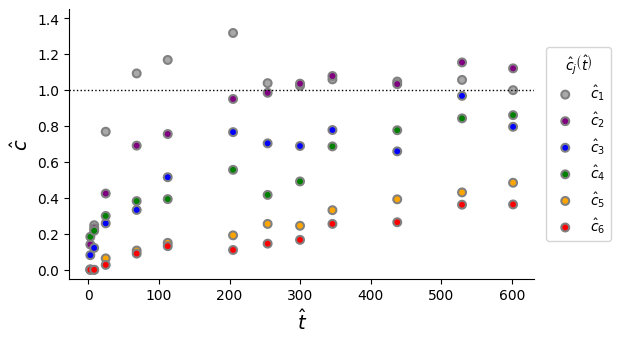

In [10]:
experimental_data.plot_breakthrough()

Finished solve() in 4.1201 secs


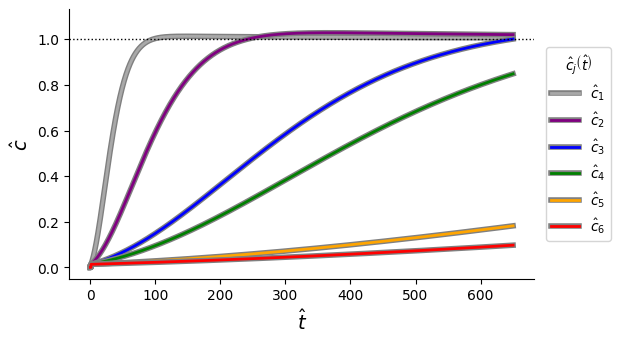

In [11]:
p = PhysicalParams(
    L=lenght,
    v=pore_velocity,
    n=porosity,
    sm=5000.0,
    k_ads=(50, 50, 50, 50, 50, 50),
    k_des=(1.5, 0.5, 0.15, 0.10, 0.02, 0.01),
)

sim = Simulation(**p.nondim)
sim.end_time = 650
sim.cfl = 0.9
sim.solve()
sim.plot_breakthrough()

In [27]:
def f(
    times_to_query,
    sm,
    kads_1,
    kads_2,
    kads_3,
    kads_4,
    kads_5,
    kads_6,
    kdes_1,
    kdes_2,
    kdes_3,
    kdes_4,
    kdes_5,
    kdes_6,
):
    k_ads = (kads_1, kads_2, kads_3, kads_4, kads_5, kads_6)
    k_des = (kdes_1, kdes_2, kdes_3, kdes_4, kdes_5, kdes_6)

    p = PhysicalParams(
        L=lenght,
        v=pore_velocity,
        n=porosity,
        sm=sm,
        k_ads=k_ads,
        k_des=k_des,
    )

    sim = Simulation(**p.nondim)
    sim.end_time = 650
    sim.cfl = 0.9
    sim.solve()

    # Query the btc from t
    t, btc = sim.btc
    results = [np.interp(times_to_query, t, c) for c in btc]
    results = np.array(results)
    return results.flatten()


In [33]:
p0 = (
    5000,  # sm
    *(50, 50, 50, 50, 50, 50),  # kads
    *(1.5, 0.5, 0.15, 0.10, 0.02, 0.01),  # kdes
)

print(f(experimental_data.time, *p0))

Finished solve() in 0.9388 secs
[0.02750251 0.09333351 0.39472057 0.93333961 1.00968829 1.01188246
 1.01089941 1.01012349 1.00943255 1.00823864 1.00727579 1.00666731
 0.0178135  0.03464015 0.1057547  0.38658379 0.66289809 0.96161627
 1.00842971 1.02403462 1.02829111 1.02695146 1.02369696 1.02150083
 0.01473474 0.01930557 0.03531358 0.09429185 0.17290419 0.37443878
 0.48552993 0.58454252 0.67491665 0.82234778 0.92404955 0.97666223
 0.01430836 0.0173576  0.0276075  0.06307336 0.10928235 0.23369049
 0.30920693 0.382605   0.45628608 0.59708447 0.72058399 0.80220814
 0.01363319 0.01437015 0.01665407 0.02329288 0.03072498 0.04903711
 0.06019465 0.0715441  0.08372854 0.11042517 0.13989783 0.16481922
 0.0135494  0.01400797 0.01540696 0.0192987  0.02344691 0.03313822
 0.03881427 0.04447386 0.05045577 0.06333427 0.07734525 0.08912544]


In [36]:
## No bias, all observations are equal
p0 = (
    5000,  # sm
    *(50, 50, 50, 50, 50, 50),  # kads
    *(1.5, 0.5, 0.15, 0.10, 0.02, 0.01),  # kdes
)

bounds = Bounds(
    lb=[1, *(0.01, 0.01, 0.01, 0.01, 0.01, 0.01), *(0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001)],
    ub=[10000, *(100, 100, 100, 100, 100, 100), *(10, 10, 10, 10, 10, 10)],
)

ydata = experimental_data.conc

fitting_result = curve_fit(
    f,
    xdata=experimental_data.time,
    ydata=ydata.flatten(),
    p0=p0,
    bounds=bounds,
    # sigma=sigma.flatten(),
    # absolute_sigma=True,
    method="trf",
    loss="soft_l1",
    full_output=True,
)

Finished solve() in 0.8828 secs
Finished solve() in 0.8489 secs
Finished solve() in 0.8333 secs
Finished solve() in 0.8490 secs
Finished solve() in 0.8428 secs
Finished solve() in 0.8397 secs
Finished solve() in 0.8454 secs
Finished solve() in 0.8427 secs
Finished solve() in 0.8413 secs
Finished solve() in 0.8326 secs
Finished solve() in 0.8337 secs
Finished solve() in 0.8338 secs
Finished solve() in 0.8251 secs
Finished solve() in 0.8322 secs
Finished solve() in 0.8319 secs
Finished solve() in 0.8371 secs
Finished solve() in 0.8392 secs
Finished solve() in 0.8393 secs
Finished solve() in 0.8323 secs
Finished solve() in 0.8437 secs
Finished solve() in 0.8379 secs
Finished solve() in 0.8889 secs
Finished solve() in 0.8662 secs
Finished solve() in 0.8472 secs
Finished solve() in 0.8407 secs
Finished solve() in 0.8589 secs
Finished solve() in 0.8562 secs
Finished solve() in 0.8445 secs
Finished solve() in 0.8357 secs
Finished solve() in 0.8317 secs
Finished solve() in 0.8285 secs
Finished

In [37]:
fitting_result[0]

array([3.20820377e+03, 4.89943936e+01, 1.93629419e+01, 1.86957545e+01,
       1.73036934e+01, 3.42319567e+01, 3.93632565e+01, 2.95562940e+00,
       2.88420665e-01, 6.91278275e-02, 4.28843117e-02, 3.38509608e-02,
       2.94488636e-02])

PhysicalParams(L=0.85, v=9.645754126781533, n=0.5, sm=np.float64(3208.2037707253216), k_ads=array([48.9943936 , 19.36294192, 18.69575453, 17.30369341, 34.23195669,
       39.36325649]), k_des=array([2.9556294 , 0.28842067, 0.06912783, 0.04288431, 0.03385096,
       0.02944886]), C_0=array([1., 1., 1., 1., 1., 1.]))

Finished solve() in 3.7510 secs


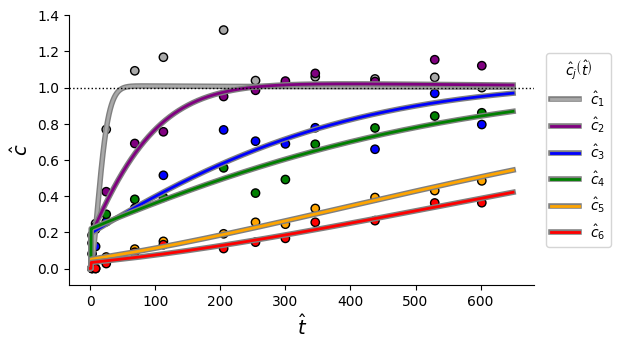

In [ ]:
best_params = fitting_result[0]

p = PhysicalParams(
    L=lenght,
    v=pore_velocity,
    n=porosity,
    sm=best_params[0],
    k_ads=best_params[1:7],
    k_des=best_params[7:],
)

display(p)

nsim = Simulation(**p.nondim)
nsim.end_time = 650
nsim.cfl = 0.9
nsim.solve()

fig = nsim.plot_breakthrough()
ax = fig.axes[0]
colors = cycle(["darkgrey", "purple", "blue", "green", "orange", "red"])

for btc, color in zip(experimental_data.conc, colors):
    ax.scatter(
        experimental_data.time,
        btc,
        c=color,
        path_effects=[Stroke(linewidth=1, foreground="#000")],
    )

ax.set_ylim(bottom=-0.09, top=1.4)
display(fig)

In [ ]:
## With bias on certain observed points
p0 = (
    5000,  # sm
    *(50, 50, 50, 50, 50, 50),  # kads
    *(1.5, 0.5, 0.15, 0.10, 0.02, 0.01),  # kdes
)

bounds = Bounds(
    lb=[1, *(0.01, 0.01, 0.01, 0.01, 0.01, 0.01), *(0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001)],
    ub=[10000, *(100, 100, 100, 100, 100, 100), *(10, 10, 10, 10, 10, 10)],
)

ydata = experimental_data.conc
sigma = np.ones_like(ydata) * 0.1
sigma[0, 2:7] = 0.01

fitting_result_bias = curve_fit(
    f,
    xdata=experimental_data.time,
    ydata=ydata.flatten(),
    p0=p0,
    bounds=bounds,
    sigma=sigma.flatten(),
    absolute_sigma=True,
    method="trf",
    loss="soft_l1",
    full_output=True,
)

Finished solve() in 0.8447 secs
Finished solve() in 0.8612 secs
Finished solve() in 0.8519 secs
Finished solve() in 0.8415 secs
Finished solve() in 0.8471 secs
Finished solve() in 0.8527 secs
Finished solve() in 0.8556 secs
Finished solve() in 0.8410 secs
Finished solve() in 0.8454 secs
Finished solve() in 0.8316 secs
Finished solve() in 0.8439 secs
Finished solve() in 0.8437 secs
Finished solve() in 0.8381 secs
Finished solve() in 0.8465 secs
Finished solve() in 0.8531 secs
Finished solve() in 0.8486 secs
Finished solve() in 0.8560 secs
Finished solve() in 0.8933 secs
Finished solve() in 0.8660 secs
Finished solve() in 0.8734 secs
Finished solve() in 0.8824 secs
Finished solve() in 0.8445 secs
Finished solve() in 0.8505 secs
Finished solve() in 0.8505 secs
Finished solve() in 0.8741 secs
Finished solve() in 0.8992 secs
Finished solve() in 0.8641 secs
Finished solve() in 0.8938 secs
Finished solve() in 0.9198 secs
Finished solve() in 0.8504 secs
Finished solve() in 0.8731 secs
Finished

In [ ]:
best_params_bias = fitting_result_bias[0]

p = PhysicalParams(
    L=lenght,
    v=pore_velocity,
    n=porosity,
    sm=best_params_bias[0],
    k_ads=best_params_bias[1:7],
    k_des=best_params_bias[7:],
)

display(p)

nsim = Simulation(**p.nondim)
nsim.end_time = 650
nsim.cfl = 0.9
nsim.solve()

fig = nsim.plot_breakthrough()
ax = fig.axes[0]
colors = cycle(["darkgrey", "purple", "blue", "green", "orange", "red"])

for btc, color in zip(experimental_data.conc, colors):
    ax.scatter(
        experimental_data.time,
        btc,
        c=color,
        path_effects=[Stroke(linewidth=1, foreground="#000")],
    )

ax.set_ylim(bottom=-0.09, top=1.4)
display(fig)